# Homework 2: Dijstrka and Ising



# Part 1 - Find your way in Paris


For many of you this is the first year in Paris, one of the most cosmopolitan city in the world. During this homework we will help you building your home-made navigator using the Dijstrka algorith (see [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)).

Moreover you will challenge yourself on how to create nice and readable plots using Python.

## Data loading

By running the below cells, you will download all the required data. You can also download them manually and put them in the same folder of the notebook.

In [1]:
#libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### Map data preparation

Run the cells below to download the data about the map of Paris.

In [2]:
#this are the data used for plotting the map of Paris
! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/arrondissements-millesimes0.csv"

--2022-10-17 15:10:10--  https://github.com/Schimmenti/NumPhysENS/raw/master/arrondissements-millesimes0.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/arrondissements-millesimes0.csv [following]
--2022-10-17 15:10:11--  https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/arrondissements-millesimes0.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104777 (102K) [text/plain]
Saving to: ‘arrondissements-millesimes0.csv.2’

arrondissements-mil 100%[===================>] 102,32K  --.-KB/s    in 0,01s   

2022-10-17 15:10:12 (9,24 MB/s) - ‘arrondissemen

In [3]:
# run this code to create a list of the coordinates of the different arrondissements of Paris
arrondis = pd.read_csv("arrondissements-millesimes0.csv", delimiter=";")
arrondis = arrondis[arrondis.Commune.str.contains("PARIS")]
shapes = arrondis.geo_shape
coords = []
arr_names = arrondis.nom_com.values
for shape in shapes:
  temp=json.loads(shape)
  coords.append(np.array(temp['coordinates'])[0,...])
#'coords' is a list of the points making up the perimeter of each arrondissement in Paris
# i.e. coords[0] is a (M,2) matrix with M the number of points
# by using plt.plot(coords[0][:,0],coords[0][:,1]) you can plot the whole arrondissement.
# the important variables here are 'coords' and 'arr_names' i.e. the coordinates and the name of the arrondissement.

### Data preparation

Run the two cells below to (i) download the data and (ii) create the networks.  Note that the run time of the second cell is longer and might take one minute.
* Each node of the network is labeled by a unique code and represents a single line station of the Paris transportation network (metro, rer, tram or bus) as of 2018. For example the metro station *Jussieu* is associated to two codes (282 ans 283) one for the metro line 7  and the other for the metro line 10. 

* The dictionary 'net' contains the information about the neighbors of a given node. To find the list of nodes that you can reach from the node 'i' you may use:
```
net[i]
```
* The time (in seconds) taken to travel from the station i to the neighoring station j is given in the nested dictionary 'durations':
```
durations[i][j]
```
This duration represents either the time taken by the public transport (bus, metro...) to connect two consecutive stations or the estimated walking time needed for the change. Note that the network is directed as 'durations[i][j]' can be different from 'durations[j][i]'.


In [4]:
#this is the data used for plotting the map of Paris
! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/network_nodes.csv"
! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_combined.csv"
! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_walk.csv"

--2022-10-17 15:10:12--  https://github.com/Schimmenti/NumPhysENS/raw/master/network_nodes.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_nodes.csv [following]
--2022-10-17 15:10:14--  https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_nodes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707846 (691K) [text/plain]
Saving to: ‘network_nodes.csv.1’

network_nodes.csv.1 100%[===================>] 691,26K  --.-KB/s    in 0,09s   

2022-10-17 15:10:14 (7,47 MB/s) - ‘network_nodes.csv.1’ saved [707846/707846]

--2022-10-17 15:10:15--  

In [5]:
net_names = pd.read_csv("network_nodes.csv", delimiter=";")
def search_station(src_string):
  return net_names[net_names.name.str.contains(src_string, case=False)]
def station_name(id):
  return net_names[net_names.stop_I == id].name.values[0]
def station_position(id):
  line = net_names[net_names.stop_I == id]
  return line.lon.values[0], line.lat.values[0]
combined = pd.read_csv("network_combined.csv", delimiter=";")
walk = pd.read_csv("network_walk.csv", delimiter=";")
walk_symm = walk.copy()
walk_symm.from_stop_I = walk.to_stop_I
walk_symm.to_stop_I = walk.from_stop_I
walk = walk.append(walk_symm)
walk = walk.sort_values(by='from_stop_I')
walk = walk.reset_index(drop=True)
final_net = combined.merge(walk, on=['from_stop_I','to_stop_I'], how='outer')
final_net = final_net[["from_stop_I",	"to_stop_I","duration_avg","d_walk"]]
final_duration = np.fmin(final_net.duration_avg,final_net.d_walk)
final_net["duration"] = final_duration
max_idx = max(np.max(final_net["from_stop_I"].values),np.max(final_net["to_stop_I"].values))
min_idx = min(np.min(final_net["from_stop_I"].values),np.min(final_net["to_stop_I"].values))
net ={}
for i in range(min_idx, max_idx+1):
    net[i] = []
durations = {}
for id, g in final_net.groupby('from_stop_I'):
    net[id].extend(list(g["to_stop_I"].values))
    durations[id] = {}
    for _,line in g.iterrows():
      #durations[id][line.to_stop_I] = line.duration  #old line of code, bug due to change in version
      durations[id][int(line.to_stop_I)] = line.duration

## Implementation of the Dijkstra algorithm

Complete the following code to implement the Dijkstra algorithm for this network 

In [6]:
def dijkstra(net, durations, source, destination):
  network=net.copy() #leave unchanged the original dic
  #dur_src[i] should contain (at the end) the duration (in seconds) that it takes to go from 'source' to 'i'
  dur_src = {}
  #previous_node[i] should contain (at the end) the node preceding 'i' in the minimal-distance path between 'source' and 'i'
  previous_node = {}
  #this for-loop initializes correctly dur_src and previous_node  
  for k in network.keys():
    dur_src[k] = np.infty
    previous_node[k] = None
  #naturally 'source' has duration '0' from itself
  dur_src[source] = 0
  dest_check = 0
  while dest_check == 0:
    dur_unvisited={ un_key: dur_src[un_key] for un_key in network.keys()}
    current = min(dur_unvisited, key= dur_unvisited.get)
    nn = network.pop(current)
    for i in nn:
      new_dis = durations[current][i] + dur_src[current]
      if (new_dis < dur_src[i]): 
        dur_src[i] = new_dis
        previous_node[i] = current
    if current == destination: dest_check = 1
  return dur_src, previous_node



We give you an hint for such implementation. Use the same trick we used to construct the clusters in the Wolff algorithm. In order to explore the network more efficiently it is better to pop the elements in 'border' starting from the oldest one (e.g. the one that we added first during the exploration). To do this simply use the function .pop(0) instead of .pop(). Namely:

```
border = [source]
  while(len(border)>0):
    next_node = border.pop(0)
```

Use [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)! It provides you a nice pseudocode to start understanding the algorithm:

    function Dijkstra(Graph, source):
       
       for each vertex v in Graph.Vertices:
           dist[v] ← INFINITY
           prev[v] ← UNDEFINED
           add v to Q
       dist[source] ← 0
       
       while Q is not empty:
          u ← vertex in Q with min dist[u]
          remove u from Q
          
          for each neighbor v of u still in Q:
              alt ← dist[u] + Graph.Edges(u, v)
              if alt < dist[v]:
                  dist[v] ← alt
                  prev[v] ← u

      return dist[], prev[]


## Question 1

After the Friday lesson you have been invited to a party held at 358 rue de Pyrénées. The closest metro station is *Pyrénées* (with code 146). From 24 rue Lhomond the closest metro station is *Place Monge - Jardin des Plantes* (with code 42). Compute the minimal duration of the trip to reach the party.


In [7]:
from datetime import timedelta

test_source=42
test_destination=146

test_dur_src , test_previous_node= dijkstra(net, durations, source=test_source, destination=test_destination)
print(" travel time from station", station_name(test_source), " -> station", \
    station_name(test_destination)," : ", timedelta(seconds=test_dur_src[test_destination]))

 travel time from station Place Monge (Jardin des Plantes)  -> station Pyrénées  :  0:18:22.356332


## Question 2

Reconstruct the full path listing all the intermediate stations and the time (in minutes) taken to reach them. The final result should look like:
```
Station: 42 Time: 0
Station: yyyy Time: zzzz
(omissis)
Station: 146 Time: xxxx
```

In [8]:
def path(source, destination, previous_node):
    traj=[destination]
    while (traj[-1] != source):
        traj.append(previous_node[traj[-1]])
    traj=traj[::-1]
    return traj

def time_table(path, dur_src):
    print("time format: hh:mm:ss")
    path_time= [dur_src[station] for station in path]
    for i in range(len(path)):
        print("-station:", station_name(path[i]), "---time:", timedelta(seconds=path_time[i]))

In [9]:
test_path=path(test_source, test_destination, test_previous_node)
time_table(test_path, test_dur_src)

time format: hh:mm:ss
-station: Place Monge (Jardin des Plantes) ---time: 0:00:00
-station: Jussieu ---time: 0:01:25.303030
-station: Sully-Morland ---time: 0:03:15.909091
-station: Pont Marie (Cité des Arts) ---time: 0:04:28.181818
-station: Châtelet ---time: 0:05:56.969697
-station: Châtelet ---time: 0:09:39.969697
-station: Hôtel de Ville ---time: 0:10:39.969697
-station: Rambuteau ---time: 0:11:45.124828
-station: Arts-et-Métiers ---time: 0:13:03.024590
-station: République ---time: 0:14:29.516236
-station: Goncourt (Hôpital Saint-Louis) ---time: 0:15:45.268026
-station: Belleville ---time: 0:16:51.711940
-station: Pyrénées ---time: 0:18:22.356332


## Question 3
* Represent your results on the map of Paris and indicate the name of each station in the path.

* To do this we provide two functions:
  1.   A function 'station_name(id)' that, given the code of the station, returns its name:
    ```
    station_name(42)
    ```
  2.   A function 'station_position(id)' that, given the code of the station, returns its GPS coordinates as a tuple i.e. (x,y):
  ```
    station_position(42)
    ```
* We provide also a code below that generates an empty map. All the data needed to do so have been downloaded in section 'Data loading'. Modify the code in order to answer the question.

In [10]:
def path_info(path):
    names=[]
    coordinates=[]
    for j in path:
        names.append(station_name(j))
        coordinates.append(station_position(j))
    coordinates=np.reshape(coordinates, [len(coordinates), 2])
    return names, coordinates
test_names, test_coor=path_info(test_path)

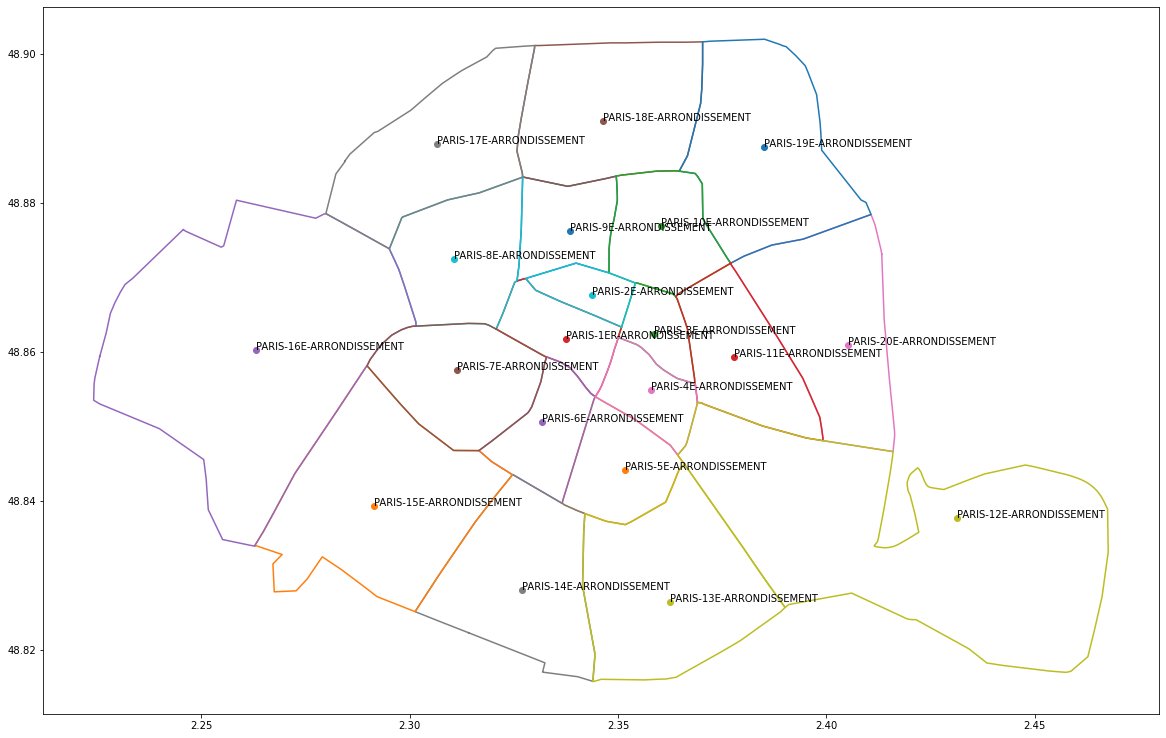

In [11]:
#the variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section.
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
  #plots the perimeter
  plt.plot(coord[:,0],coord[:,1])
  #centroid of the arrondissement 
  x_avg = np.mean(coord[:,0])
  y_avg = np.mean(coord[:,1])
  #adds a text and a bullet at the centroid of the arr.
  plt.text(x_avg,y_avg,arr_names[idx])
  plt.scatter(x_avg,y_avg)
plt.show()

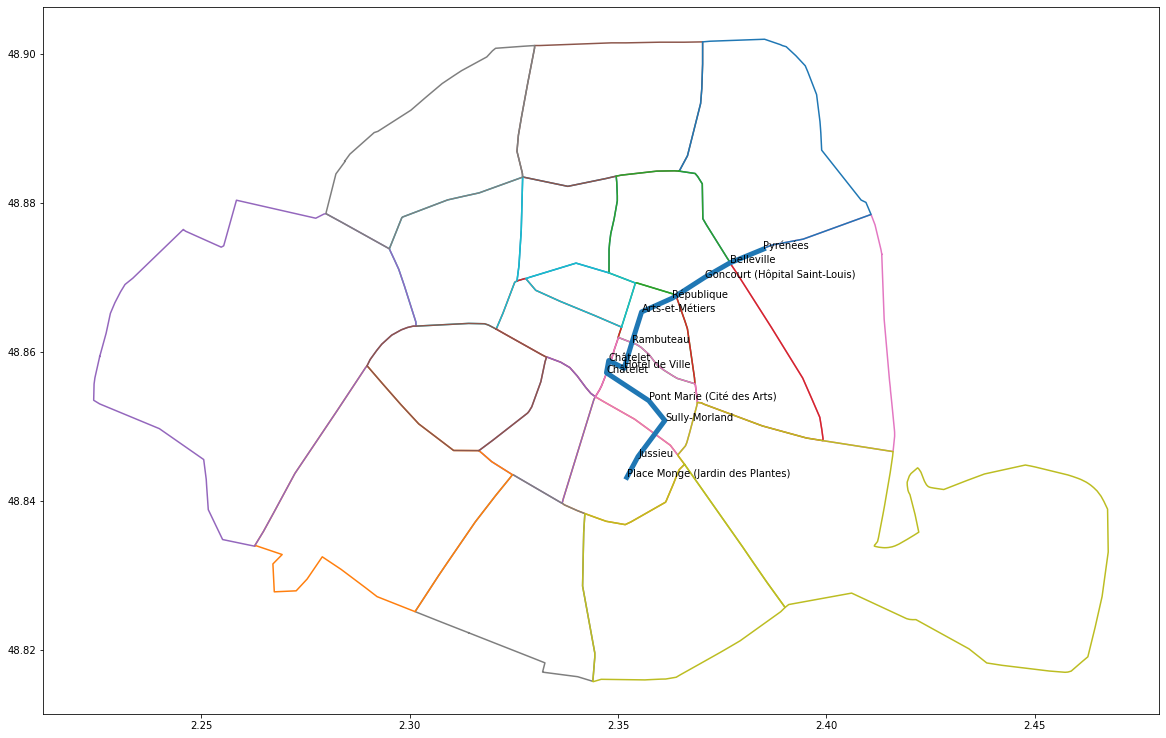

In [12]:
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
  #plots the perimeter
  plt.plot(coord[:,0],coord[:,1])
plt.plot(test_coor[:,0], test_coor[:,1], lw=5)
for station in range(len(test_path)):
  plt.text(test_coor[station][0], test_coor[station][1] ,test_names[station])

plt.show()

## Question 4

A big social protest is taking place in Jussieu and the metro stations with codes 282 and 283 are closed. Find an alternative itinerary to reach the party. Provide its duration and map.

### Hint
Since Jussieu is closed for the whole day, the duration of the connections to and from Jussieu become one day longer (i.e. 86400 seconds). In order to avoid Jussieu modify the nested-dictionary 'durations' and add at the appropriate spots this time delay.


In [13]:
closed=[282, 283]
day=86400
updated_durations= durations.copy()

for station in closed:
    nn_closed=net[station]
    for nn in nn_closed:
        updated_durations[station][nn]+=day
        updated_durations[nn][station]+=day

new_dur_src , new_previous_node= dijkstra(net, updated_durations, source=test_source, destination=test_destination)
print(" travel time from station", station_name(test_source), \
    " -> station", station_name(test_destination)," : ", timedelta(seconds=new_dur_src[test_destination]))

 travel time from station Place Monge (Jardin des Plantes)  -> station Pyrénées  :  0:22:02.416092


In [14]:
new_path=path(test_source, test_destination, new_previous_node)
time_table(new_path, new_dur_src)

time format: hh:mm:ss
-station: Place Monge (Jardin des Plantes) ---time: 0:00:00
-station: MONGE ---time: 0:00:45
-station: CARDINAL LEMOINE ---time: 0:02:55
-station: Cardinal-Lemoine ---time: 0:03:27
-station: Maubert-Mutualité ---time: 0:04:43.279070
-station: Cluny-La Sorbonne ---time: 0:05:46.069767
-station: Odéon ---time: 0:06:48.162791
-station: Odéon ---time: 0:07:18.162791
-station: Saint-Michel ---time: 0:08:31.362791
-station: Cité ---time: 0:09:31.896124
-station: Châtelet ---time: 0:10:58.029457
-station: Châtelet ---time: 0:13:20.029457
-station: Hôtel de Ville ---time: 0:14:20.029457
-station: Rambuteau ---time: 0:15:25.184589
-station: Arts-et-Métiers ---time: 0:16:43.084350
-station: République ---time: 0:18:09.575997
-station: Goncourt (Hôpital Saint-Louis) ---time: 0:19:25.327787
-station: Belleville ---time: 0:20:31.771701
-station: Pyrénées ---time: 0:22:02.416092


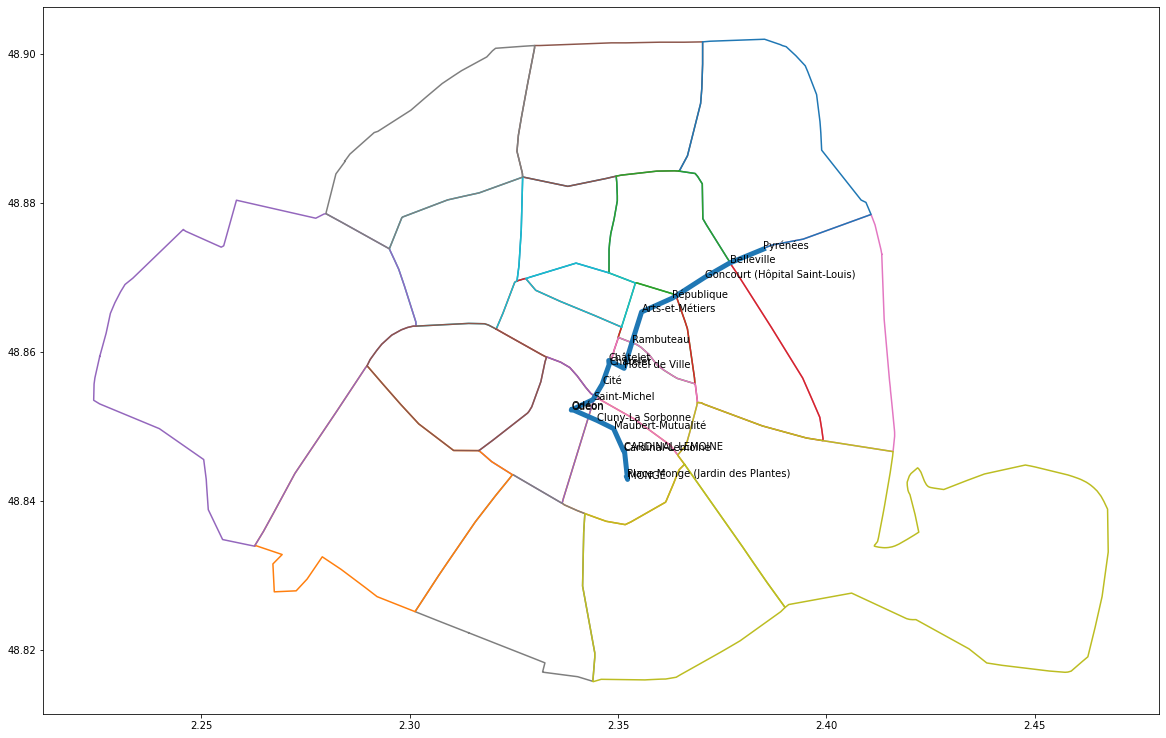

In [15]:
new_names, new_coor=path_info(new_path)
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
  #plots the perimeter
  plt.plot(coord[:,0],coord[:,1])
plt.plot(new_coor[:,0], new_coor[:,1], lw=5)
for station in range(len(new_path)):
  plt.text(new_coor[station][0], new_coor[station][1] ,new_names[station])

plt.show()

# Part 2 - Further exploration of the Ising model

In this second part, you will be interested in the two-dimensional Ising model.
As a reminder, the Ising model describes a set of spins sitting on the sites
of a given lattice. You will consider the **periodic** two-dimensional square
lattice with $N = L \times L$ sites. The spin sitting on the site $j$ is described by
a variable $\sigma_j = \pm 1$. The energy for
a given configuration $\{ \sigma \}$ of spins is

$$
E(\{\sigma\}) = -J\sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\langle i j \rangle$ indicates that $i$ and $j$ are
nearest-neighbors on the lattice. In the following, you will consider the
ferromagnetic case $J>0$ and use $J=1$ as the unit of energy.
The Ising model has a phase transition at the critical temperature

$$
T_c = \frac{2}{\ln(1+\sqrt{2})} = 2.269185\ldots
$$

## The Glauber algorithm

During the lecture, you have studied three different Monte Carlo algorithms for the Ising model. Here, you will investigate one more: the Glauber algorithm.
Just like the heat-bath it is also a rejection-free
algorithm. The algorithm follows these steps:

1. Pick a random site $i$ on the lattice

2. Flip the spin $\sigma_i$ on site $i$ to $-\sigma_i$ with probability:

   $$
    P^\mathrm{flip}_i = \frac{1}{1 + \exp(\beta \, 2 J \sigma_i h_i)}
   $$
   
   where $h_i$ is the molecular field on the site $i$:
   
   $$
   h_i = \sum_{j \, \in \, \text{neighbors of $i$}} \sigma_j
   $$
   
3. Go back to step 1.

### Question 5

Prove that the Glauber algorithm leads to a sampling of the configurations that follows the Boltzmann distribution.

#### Answer 5

Given that we showed that the heat bath algorithm satisfies detailed balance, in order to prove that even the Glauber algorithm does, we can prove that it is equivalent to the heat bath algorithm. 

- If $\sigma_i=1$: then $P^{flip}_i$ play the role of $\pi_-$ in the HB alg. 
- If $\sigma_i=-1$: then $P^{flip}_i$ play the role of $\pi_+$ in the HB alg. 

Then due to $\mathcal{Z}_2$ symmetry the two algorithms are equivalent

### Question 6

Implement the Glauber algorithm and compare your results to those
  obtained with the Wolff algorithm.
  More specifically, use both algorithms to compute: the absolute value of the magnetization,
  the specific heat, the energy and the susceptibility as a function of temperature.
  Use a $6 \times 6$ lattice and 10 temperatures in the range $[0.5, 4.0]$.
  
  The function that implements the Glauber algorithm can have the signature
  ```python
def glauber(config, T)
    # your code
  ```
  where `config` is a spin configuration to be modified by the Glauber algorithm and `T`
  is the temperature. Just like for the heat bath, let the function apply a total of
  $N = L \times L$ proposal moves.
  
  When running
  the Wolff algorithm, use the implementation below. It is an improved version of the algorithm
  that we have used in the lecture that runs a bit faster:

  ```python
def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1
   ```

#### Answer 6

_A code as well as 4 plots showing a comparison between the algorithms are expected._

In [16]:
def compute_energy(config): 
    L = config.shape[0]
    energy = 0
    for i in range(L):
        for j in range(L):
            energy -= config[i,j] * (config[(i+1)%L, j] + config[i, (j+1)%L])
    return energy

def compute_magnetization(config): return np.sum(config)


def monte_carlo(L, T, method, n_steps):
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    magnetizations = np.zeros(n_steps)
    energies = np.zeros(n_steps)
    for i in range(n_steps):
        method(spin_configuration, T)
        energies[i] = compute_energy(spin_configuration)
        magnetizations[i] = compute_magnetization(spin_configuration)   
    en = np.mean(energies) / L**2
    mag = np.mean(np.abs(magnetizations)) / L**2
    cv = np.var(energies) / T**2 / L**2
    chi = np.var(np.abs(magnetizations)) / T / L**2
    return en, mag, cv, chi


def glauber(config, T):  
    L = config.shape[0]
    for k in range(L**2):
        i, j = np.random.randint(L, size=2)
        h = config[(i+1)%L, j] + config[(i-1)%L, j] + \
            config[i, (j+1)%L] + config[i, (j-1)%L]
        pi_flip = 1 / (1 + np.exp(2 / T * h * config[i][j]))
        if np.random.rand() < pi_flip:
            config[i, j]*=-1

def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1

In [17]:
L = 6
T_range=np.linspace(0.5, 4, 10)

obs_g=[]
obs_w=[]
N_steps = np.power(2,12)
for T in T_range:
    temp = monte_carlo(L, T , glauber, N_steps)
    obs_g.append(temp)
    temp = monte_carlo(L, T , wolff, N_steps)
    obs_w.append(temp)
obs_g = np.reshape(obs_g, [len(T_range), 4]) #4 observables: e, m, cv, chi
obs_w = np.reshape(obs_w, [len(T_range), 4]) 

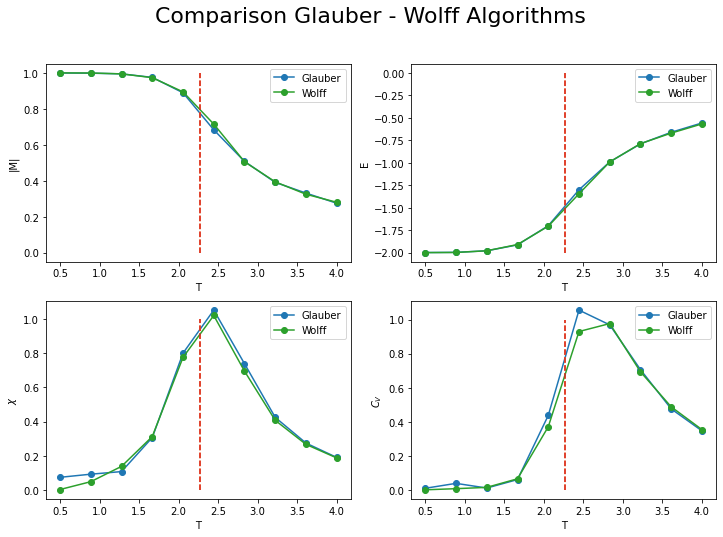

In [18]:
Tc = 2 / np.log(1 + np.sqrt(2))
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
i=0
method=["Glauber", "Wolff"]
fig.suptitle("Comparison Glauber - Wolff Algorithms", fontsize=22)
for obs in [obs_g, obs_w]:
    ax[0,1].plot(T_range, obs[:,0], '-o', label=method[i])
    ax[0,1].plot([Tc, Tc], [-2, 0], '--')
    ax[0,1].set_xlabel("T")
    ax[0,1].set_ylabel("E")
    ax[0,1].legend()

    ax[0,0].plot(T_range, np.abs(obs[:,1]), '-o', label=method[i])
    ax[0,0].plot([Tc, Tc], [0, 1], '--')
    ax[0,0].set_xlabel("T")
    ax[0,0].set_ylabel("|M|")
    ax[0,0].legend()

    ax[1,0].plot(T_range, obs[:,2], '-o', label=method[i])
    ax[1,0].plot([Tc, Tc], [0, 1], '--')
    ax[1,0].set_xlabel("T")
    ax[1,0].set_ylabel("$\chi$")
    ax[1,0].legend()

    ax[1,1].plot(T_range, obs[:,3], '-o', label=method[i])
    ax[1,1].plot([Tc, Tc], [0, 1], '--')
    ax[1,1].set_xlabel("T")
    ax[1,1].set_ylabel("$C_V$")
    ax[1,1].legend()

    i+=1
plt.show()
    

## Cluster size histogram

In this section, you will investigate the distribution of cluster sizes in the Wolff cluster
algorithm. In particular, you will study what are the cluster sizes that are sampled
in different regimes of the Ising model: low temperature, high temperature and at the critical temperature $T_c$.

### Question 7

Make a small modification to the `wolff` function given above so that it returns
  the size of the cluster that was flipped. Then, create histograms that display the distribution
  of cluster sizes that are flipped during the Monte Carlo sampling. Compute these histograms
  for 3 temperatures: $T = 0.9 T_c, T_c, 1.1 T_c$ for a system of size $32 \times 32$.
  Discuss the results.

#### Answer 7

_A code using your modified `wolff` function is expected, together with 3 histogram plots and a discussion of the results._

In [19]:
def modified_wolff(config, T):
    
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]
    count=1
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
        
        config[i,j] *= -1
        count+=1
    return count
        
def iterator(N_steps, T, L):
    flips_array=[]
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    for k in range(N_steps):
        temp = modified_wolff(spin_configuration, T)
        flips_array.append(temp)
    return flips_array

In [20]:
T_range=Tc*np.array([0.9, 1, 1.1])
flips_data=[]
N_steps = np.power(2,14)
L=32
for T in T_range:
    temp=iterator(N_steps, T, L)
    flips_data.append(temp)

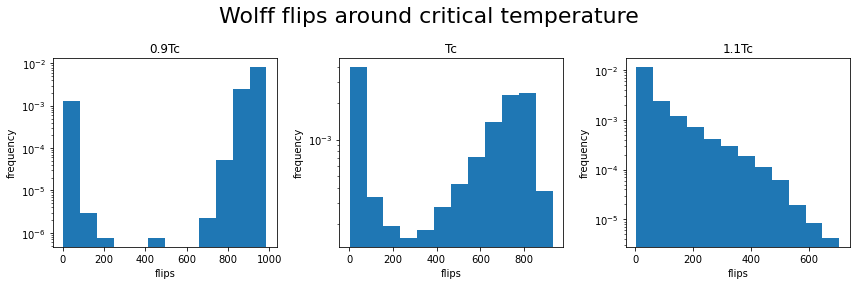

In [21]:
Tc = 2 / np.log(1 + np.sqrt(2))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Wolff flips around critical temperature", fontsize=22)
l=["0.9Tc", "Tc", "1.1Tc"]

for i in range(len(T_range)):
    ax[i].set_title(l[i])
    ax[i].hist(flips_data[i], density=True, bins=12, log=True)
    ax[i].set_xlabel("flips")
    ax[i].set_ylabel("frequency")

plt.tight_layout()
plt.show()
    

## Spin-spin correlations

In this last section, you will compute and discuss the spin-spin correlation function.
It is defined by the following average

$$
  C(r) = \langle \sigma_i \; \sigma_{i+r} \rangle
$$

This function measures how the spin at site $i$ and the spin at site $i+r$ are correlated.
In the following, you will focus on the case where $r$ is a vector along the horizontal
axis. In other words, the site $i$ and the site $i+r$ are on the same row. The correlation
function $C(r)$ does not depend on $i$ because of the translational symmetry of the lattice.
On an infinite lattice and not too far from the critical temperature, it can be shown that the correlation function has the following
behavior at large $r$:
  
$$
 C(r) \sim A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
$$

where $\xi$ is the correlation length and $A, S$ are constants. Onsager has shown that
the critical exponent $\eta = 1/4$.

### Question 8

Write a function that computes the correlation function $C(r)$ using the Wolff cluster
  Monte Carlo algorithm on a $32 \times 32$ lattice.
  Compute $C(r)$ at two temperatures: $T = 0.8 T_c$ and $T = 1.2 T_c$. Discuss the qualitative differences
  between these results (using plots of $C(r)$ in both cases).

#### Answer 8

_A code as well as two plots with a discussion of the results are expected._

In [22]:
def monte_carlo(L, T, method, n_steps):
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    magnetizations = np.zeros(n_steps)
    energies = np.zeros(n_steps)
    for i in range(n_steps):
        method(spin_configuration, T)
        energies[i] = compute_energy(spin_configuration)
        magnetizations[i] = compute_magnetization(spin_configuration)   
    en = np.mean(energies) / L**2
    mag = np.mean(np.abs(magnetizations)) / L**2
    cv = np.var(energies) / T**2 / L**2
    chi = np.var(np.abs(magnetizations)) / T / L**2
    return en, mag, cv, chi

In [23]:
def compute_C(L, T, method, n_steps):
    conf = np.random.choice([-1,1], size=(L,L))
    max_distance=int(np.floor(L/2)) #due to periodic boundary conditions
    C_r=np.zeros(max_distance)
    for i in range(n_steps):
        method(conf, T)
        for r in range(max_distance):
            shift_conf= np.roll(conf, r, axis=1)
            pw_mult=conf*shift_conf
            C=np.mean(pw_mult)
            C_r[r]+=C
    return C_r/n_steps



In [24]:
L = 32
T_range=Tc*np.array([0.8, 1.2, 0.9, 1, 1.1])

N_steps = np.power(2,14)
C_T=[]
for T in T_range:
    C_T.append(compute_C(L, T, wolff, N_steps))

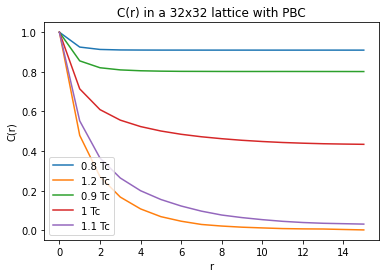

In [25]:
plt.title("C(r) in a 32x32 lattice with PBC")
plt.ylabel("C(r)")
plt.xlabel("r")
plt.plot(np.arange(L/2), C_T[0], label="0.8 Tc")
plt.plot(np.arange(L/2), C_T[1], label="1.2 Tc")
plt.plot(np.arange(L/2), C_T[2], label="0.9 Tc")
plt.plot(np.arange(L/2), C_T[3], label="1 Tc")
plt.plot(np.arange(L/2), C_T[4], label="1.1 Tc")
plt.legend()
plt.show()

### Question 9

Compute the correlation function $C(r)$ for 10 temperatures in the range
  $[T_c - 0.3, T_c + 0.3]$. Fit these correlation functions with a function of the form
  
  $$
    f_\mathrm{fit}(r) = A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
  $$

  where $A$, $S$, $\eta$ and $\xi$ are fitting parameters. Note that even though we know that $\eta = 1/4$
  from the Onsager solution, we will not assume we know that value and you should use $\eta$ as one of the
  fitting parameters. Create plots that show $C(r)$ and its fits.
  
#### Hints
  
  - Because we work with finite lattices with periodic boundary conditions, be careful
    to only use *half* of the data in $C(r)$.
    
  - The fitting function is in principle only valid for large $r$. In practice, you can
    just **ignore the first point** (at $r=0$) of the data in the fit.
      
  - You can use `scipy.optimize` to do the fits. Here is an example of how it works:
  
    ```python
    import scipy.optimize
    
    # fit function
    def fit_function(x, a, b, c):
      return # some function of (x,a,b,c)

    # data obtained by Monte Carlo
    x_values = ...
    y_values = ...
    
    # do the fit
    a, b, c = scipy.optimize.curve_fit(fit_function, x_values, y_values, bounds=[0,20])[0]
    
    ```
   
    where we have specified that the fit should only consider values for $a,b,c$ in $[0,20]$.

#### Answer 9

_A code together with 10 plots is expected._


In [26]:
L = 32
T_range=Tc+np.linspace(-0.3, 0.3, 10)
N_steps = np.power(2,15)
C_T=[]
for T in T_range:
    C_T.append(compute_C(L, T, wolff, N_steps))

In [27]:
def f(r, xi, A, S, eta): return A*np.exp(r/xi)*(xi/r)**eta + S
r_range=np.arange(1,int(np.floor(L/2)))
fit_param=[]
from scipy.optimize import curve_fit

for i in range(len(T_range)):
    params=curve_fit(f, xdata=r_range, ydata=C_T[i][1:],  p0=[100,0.1,1,1/4], bounds=[[0, 0, 0, 0], [1000, 1, 2, 2]])[0]
    fit_param.append(params)

fit_param=np.reshape(fit_param, [len(T_range),4])

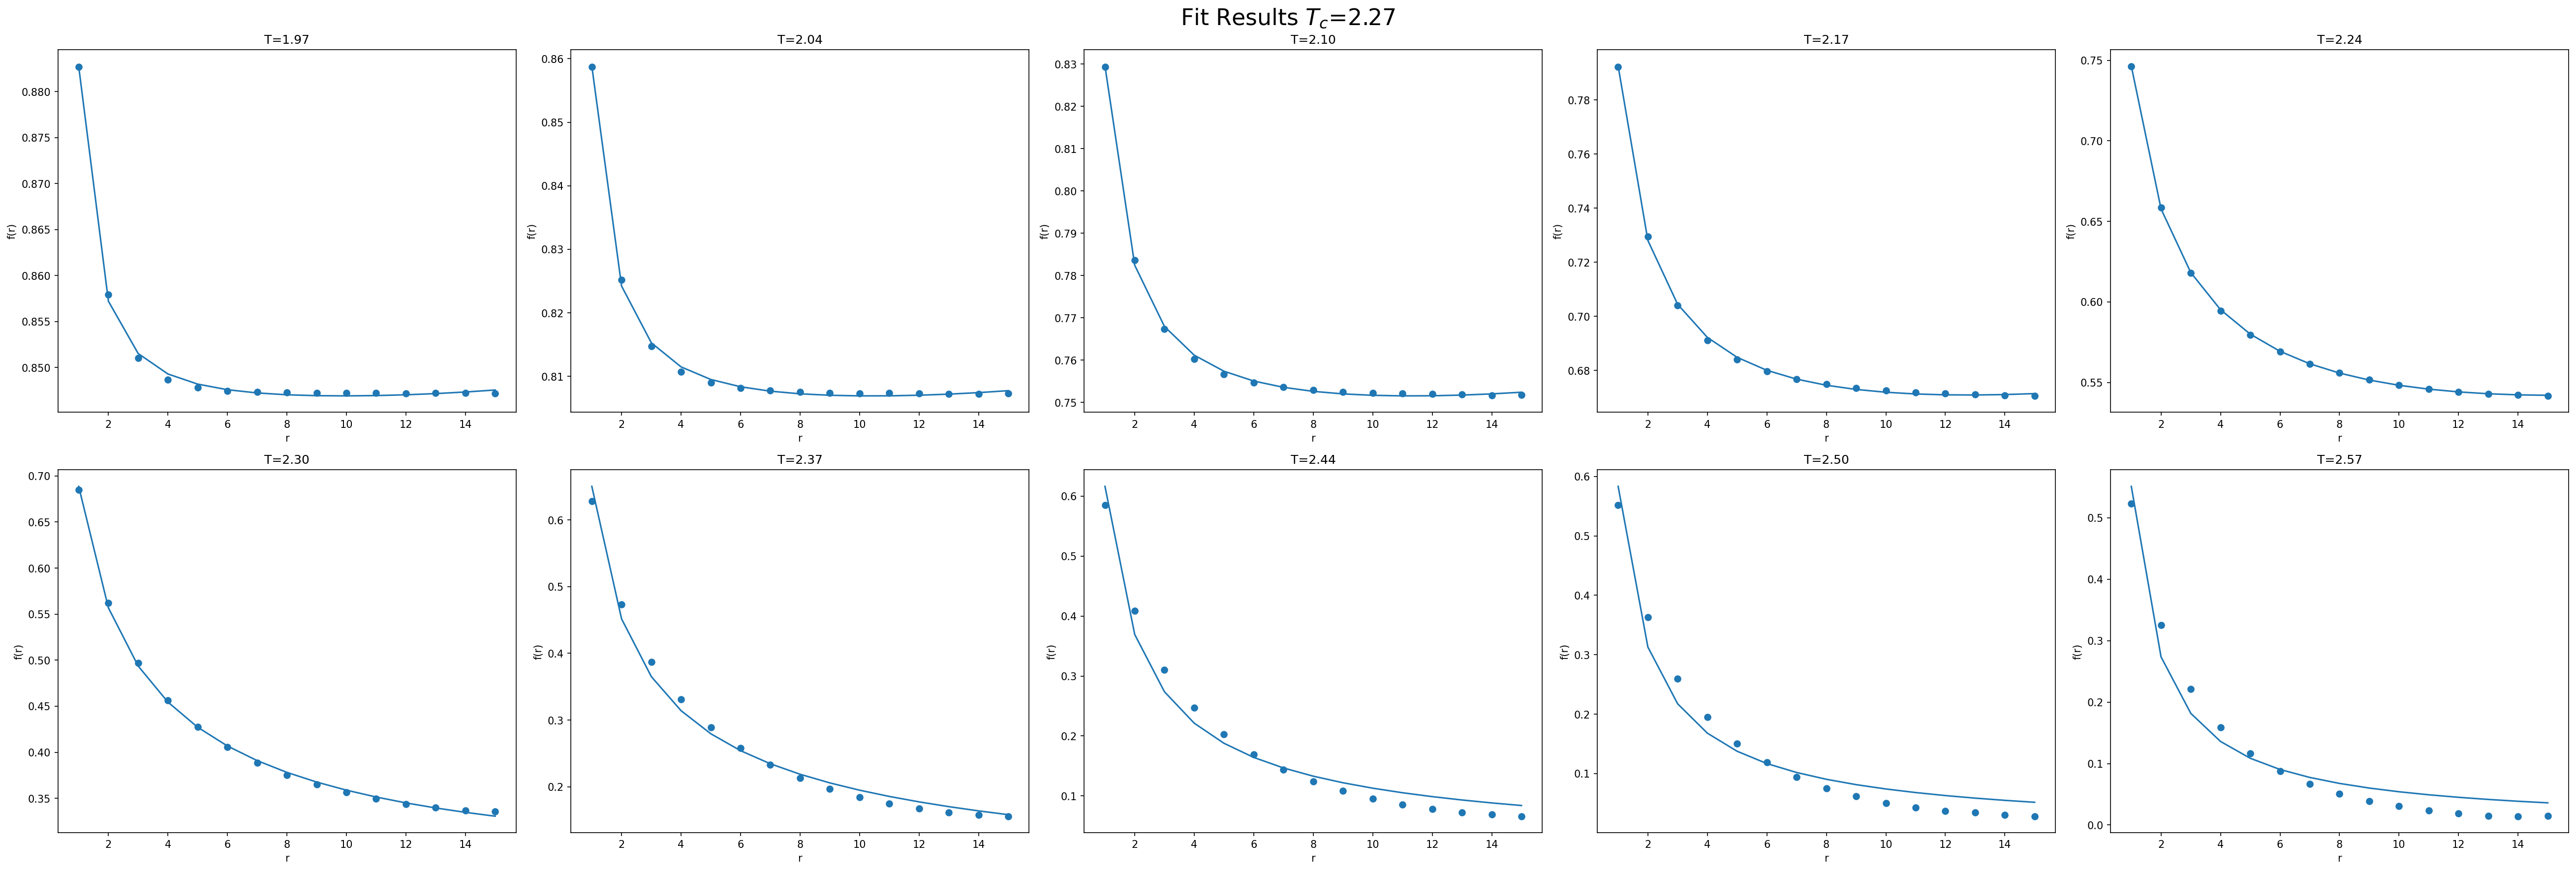

In [28]:
fig, ax = plt.subplots(2, 5, figsize=(35, 12), dpi=150)
fig.suptitle("Fit Results $T_c$=%.2f" % Tc, fontsize=22)
j=0
for i in range(len(T_range)):
    ax[j][i%5].set_title("T=%.2f" % T_range[i])
    ax[j][i%5].plot(r_range, f(r_range,*fit_param[i]))
    ax[j][i%5].scatter(r_range, C_T[i][1:])
    ax[j][i%5].set_xlabel("r")
    ax[j][i%5].set_ylabel("f(r)")
    if i==4: j=1
plt.tight_layout()
plt.show()


Notice how in the last three fits, the behavior of the data isn't really described by the fitted functions; but it isn't a drastic problem, as the function we are trying to is a reasonable approximation only around $T_C$. Around the critical point the fits seem to describe very well the points.

 ### Question 10
 
Discuss the behavior of the fitting parameters $\xi, \eta, S$ in connection with their physical meaning.

#### Answer 10

_A discussion of the results is expected. You may want to generate additional plots to support your discussion._

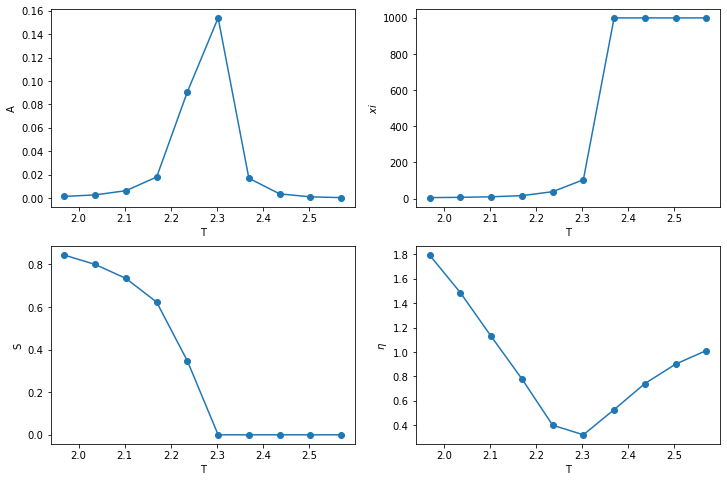

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fit_param=fit_param.T
ax[0,1].plot(T_range, fit_param[0], '-o')
ax[0,1].set_xlabel("T")
ax[0,1].set_ylabel("$xi$")

ax[0,0].plot(T_range, fit_param[1], '-o' )
ax[0,0].set_xlabel("T")
ax[0,0].set_ylabel("A")

ax[1,0].plot(T_range, fit_param[2], '-o')
ax[1,0].set_xlabel("T")
ax[1,0].set_ylabel("S")

ax[1,1].plot(T_range, fit_param[3], '-o')
ax[1,1].set_xlabel("T")
ax[1,1].set_ylabel("$\eta$")
plt.show()
    

Some observations:
- S seem to play the role of the the magnetization
- the estimation of the critical exponent $\eta$ is a little of from the theoretical value of 1/4, but finite size effects are to be taken into account in our case. Also notice that the estimation is best around the critical temperature; this was expected because the function we are fitting is a good approximation only around the critical point.
- It is hard to deal with $\xi$ because it diverges at $T_c$, hence a bound was put on it at the value of 1000 (recall that the lattice is 32x32 hence it is a reasonable choice to set such a bound). Hence, we see that $\xi$ reaches its upper bound at the critical temperature. It stays there even for $T>T_c$; but those are the plots (the three higher temperatures) for which the data isn't well described by the fit. 
